# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Задача обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 
Решить задачу можно как с помощью BERT, так и без этой нейронки.  

**План работы**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`.  
Столбец *'text'* содержит текст комментария.  
Столбец *'toxic'* — целевой признак.

## Проверка и предобработка данных

### Загрузка и проверка данных

In [1]:
# Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import time
import nltk

try:
    import torch
except:
    !pip install torch
    import torch

try:
    import transformers
except:
    !pip install transformers
    import transformers

try:
    import imblearn
except:
    !pip install imblearn
    import imblearn

import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tqdm import notebook
#from tqdm.notebook import tqdm
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [2]:
# Зададим константу
RANDOM_STATE = 42

In [3]:
# Загрузим данные
try:
    toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except:
    toxic_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])

display(toxic_comments.head())
print('-' * 40)
print(toxic_comments.info())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None


Данные содержат 159292 наблюдения. Проверим данные на наличие пропусков и дубликатов.

In [4]:
# Проверка на наличие пропусков
print(f'Количество пропущенных значений: \n{toxic_comments.isna().sum()}')

print('-' * 40)

# Проверка на наличие дубликатов
print(f'Количество дубликатов: {toxic_comments.duplicated().sum()}')

Количество пропущенных значений: 
text     0
toxic    0
dtype: int64
----------------------------------------
Количество дубликатов: 0


Пропусков и дубликатов в данных нет.  
Проверим распределение целевого признака.

In [5]:
# Проверим, какие значения в столбце с целевым признаком и их количество
toxic_comments['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Токсичность - целевой признак, он находится в столбце `toxic`. Метка `токсично` обозначена как `1`, метка `не токсично` обозначена как `0`, то есть целевой признак бинарный. Проверим распределение целевого признака.

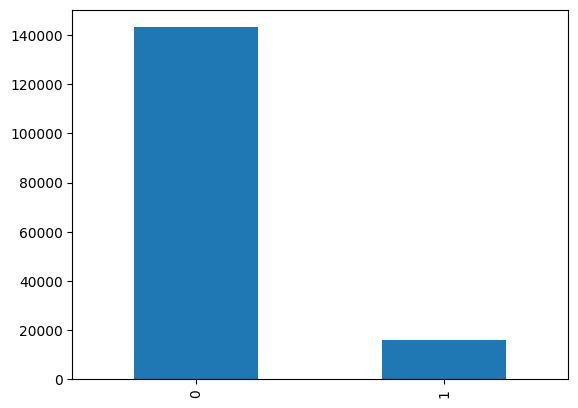

In [6]:
# Построим график распределения
toxic_comments['toxic'].value_counts().plot(kind='bar');

In [7]:
# Проверим соотношение значений
print('Соотношение:', round(toxic_comments.toxic.value_counts().max() / toxic_comments.toxic.value_counts().min(), 2))

Соотношение: 8.84


Данные несбалансированы. Значений `0` почти в 9 раз больше, чем значений `1`. На несбалансированных данных модели могут плохо предсказывать минорный класс. Чтобы модели работали адекватно, нужно решить проблему дисбаланса классов. Для этого, во-первых, при разделении выборок на тренировочную и тестовую необходимо использовать стратификацию, а во-вторых, можно либо выполнить сэмплирование тренировочной выборки, либо при инициализации моделей указать, что данные несбалансированы.    
Работаем с датасетом, в котором 159292 строки и 2 столбца.

### Предобработка текстов

Подготовку текстов к обучению моделей выполним с помощью `BERT`. Нейронные сети требуют больших вычислительных мощностей, поэтому на локальном компьютере `BERT` будет работать долго.  
Чтобы не создавать эмбеддинги слишком долго, из выборки используем только 10000 случайных элементов.

In [8]:
toxic_comments_little = toxic_comments.sample(n=10000, random_state=RANDOM_STATE)

# Проверим соотношение значений
print('Соотношение:', round(
    toxic_comments_little.toxic.value_counts().max() / toxic_comments_little.toxic.value_counts().min(), 2))

Соотношение: 8.95


Прежде чем перевести тексты в векторы, подготовим их. У BERT есть собственный токенизатор. Это инструмент, который разбивает и преобразует исходные тексты в список токенов, которые есть в словаре BERT. Лемматизация не требуется.

In [9]:
# Инициализируем токенизатор как объект класса BertTokenizer()
# передадим ему аргумент vocab_file — это файл со словарём, на котором обучалась модель
vocab_file = "C:/Users/olga/Yandex projects/12_wikishop/conversational_cased_L-12_H-768_A-12_pt_v1/vocab.txt"
tokenizer = transformers.BertTokenizer(vocab_file=vocab_file)

In [10]:
# Преобразуем текст в номера токенов из словаря методом encode() с добавлением токенов начала и конца текста
tokenized = toxic_comments_little['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

In [11]:
# Находим максимальную длину векторов после токенизации
max_len = 0

for vekt in tokenized.values:
    if len(vekt) > max_len:
        max_len = len(vekt)

print('Максимальная длина токена:', max_len)

Максимальная длина токена: 2566


Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными. Только при таком условии будет работать модель BERT. Уменьшим размер токенов до 512.

In [12]:
padded = np.array([vekt + [0]*(max_len - len(vekt)) for vekt in tokenized.values])
padded = padded[:, :512]

Теперь поясним модели, что нули не несут значимой информации. Это нужно для компоненты модели, которая называется «внимание» (англ. attention). Отбросим эти токены и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения.

In [13]:
# Создадим маску для важных токенов
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

(10000, 512)


### Создание эмбеддингов

Сформируем векторы моделью BERT.  
Инициализируем конфигурацию BertConfig. В качестве аргумента передадим ей JSON-файл с описанием настроек модели.  
Затем инициализируем саму модель класса BertModel. Передадим ей файл с предобученной моделью и конфигурацией.

In [14]:
config = transformers.BertConfig.from_json_file(
    "C:/Users/olga/Yandex projects/12_wikishop/conversational_cased_L-12_H-768_A-12_pt_v1/tokenizer_config.json"
)
model = transformers.BertModel.from_pretrained(
    "C:/Users/olga/Yandex projects/12_wikishop/conversational_cased_L-12_H-768_A-12_pt_v1/pytorch_model.bin",
    config=config,
    ignore_mismatched_sizes=True
)

Some weights of BertModel were not initialized from the model checkpoint at C:/Users/olga/Yandex projects/12_wikishop/conversational_cased_L-12_H-768_A-12_pt_v1/pytorch_model.bin and are newly initialized because the shapes did not match:
- bert.embeddings.word_embeddings.weight: found shape torch.Size([28996, 768]) in the checkpoint and torch.Size([30522, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Эмбеддинги модель BERT создаёт батчами. Чтобы хватило оперативной памяти, сделаем размер батча небольшим
batch_size = 500

# Сделаем цикл по батчам. Отображать прогресс будет функция notebook()
# сделаем пустой список для хранения эмбеддингов твитов
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    # преобразуем данные в формат тензоров
    # тип данных LongTensor хранит числа в «длинном формате», то есть выделяет на каждое число 64 бита
    # преобразуем данные
    batch = torch.LongTensor(
        padded[batch_size * i : batch_size *(i + 1)]
    )
    # преобразуем маску
    attention_mask_batch = torch.LongTensor(
        attention_mask[batch_size * i : batch_size * (i + 1)]
    )
    # чтобы получить эмбеддинги для батча, передадим модели данные и маску
    # для ускорения вычисления функцией no_grad() в библиотеке torch укажем,
    # что градиенты не нужны: модель BERT обучать не будем
    with torch.no_grad():
        batch_embeddings = model(
            batch, attention_mask=attention_mask_batch
        )
    # из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов
    # преобразуем элементы методом numpy() к типу numpy.array
    embeddings.append(batch_embeddings[0][:, 0, :].numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
# соберём все эмбеддинги в матрицу признаков вызовом функции concatenate()
features = np.concatenate(embeddings) 

### Разделение признаков

In [17]:
# Выделим признаки и целевую переменную
X = features
y = toxic_comments_little['toxic']

# Выделим тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

# Проверим размеры выборок
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7000, 768)
(7000,)
(3000, 768)
(3000,)


In [18]:
# Составим пайплайн подготовки данных и обучения модели
pipeline = Pipeline(
    [
        ('sample', SMOTE(random_state=RANDOM_STATE)),
        ('models', LogisticRegression(solver='liblinear',
                                      random_state = RANDOM_STATE))
    ]
)

pipeline

Pipeline(steps=[('sample', SMOTE(random_state=42)),
                ('models',
                 LogisticRegression(random_state=42, solver='liblinear'))])

**Выводы по предобработке данных**  

1. Данные загружены, проверены на наличие пропусков и дубликатов.
2. Выявлен дисбаланс классов.
3. Предобработка текстов выполнена с помощью нейронной сети BERT, у которой есть собственный токенизатор. Для сокращения времени обработки из выборки выбрано случайным образом 10000 наблюдений.
4. Данные разделены на тренировочную и тестовую выборки в соотношении 7:3.
5. Составлен пайплайн сэмплирования данных и обучения модели.

## Обучение моделей

In [19]:
param_distributions = [
    {
        'models': [LogisticRegression(solver = 'liblinear',
                                      random_state=RANDOM_STATE)],
        'models__penalty': ('l1', 'l2'),
        'models__C': np.linspace(1, 10, 10)#,
        #'models__class_weight': ['balanced', None]
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)]#,
        #'models__class_weight': ['balanced', None]
    },
     {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE,
                                      #auto_class_weights='Balanced',
                                      verbose=False)],
        'models__depth': range(2, 5),
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__iterations': range(200, 300, 50)
    }
]

param_distributions

[{'models': [LogisticRegression(random_state=42, solver='liblinear')],
  'models__penalty': ('l1', 'l2'),
  'models__C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
 {'models': [RandomForestClassifier(random_state=42)],
  'models__max_depth': [None, 2, 3, 4, 5, 6]},
 {'models': [<catboost.core.CatBoostClassifier at 0x1611437bca0>],
  'models__depth': range(2, 5),
  'models__learning_rate': [0.01, 0.05, 0.1],
  'models__iterations': range(200, 300, 50)}]

In [20]:
randomized_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring='f1',
    n_iter=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

In [21]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('sample', SMOTE(random_state=42)),
                                             ('models',
                                              LogisticRegression(random_state=42,
                                                                 solver='liblinear'))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'models': [LogisticRegression(random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                                         'models__penalty': ('l1', 'l2')},
                                        {'models': [RandomForestClassifier(random_state=42)],
                                         'models__max_depth': [None, 2, 3, 4, 5,
                                                               6]},
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x000001611437BCA0>],
                                         'models__depth': range(2, 5),
                                         'models__iterations': range(200, 300, 50),
                                         'models__learning_rate': [0.01, 0.05,
                                                                   0.1]}],
                   random_state=42, scoring='f1')

In [22]:
print('Best parameters:', randomized_search.best_params_)
print('Best F1 score:', round(randomized_search.best_score_, 3))

Best parameters: {'models__learning_rate': 0.05, 'models__iterations': 250, 'models__depth': 3, 'models': <catboost.core.CatBoostClassifier object at 0x000001611437BCA0>}
Best F1 score: 0.307


**Вывод по обучению моделей**  

Лучшей моделью на кросс-валидации является CatBoostRegression с гипепараметрами 'learning_rate': 0.05, 'iterations': 250, 'depth': 3. Метрика F1 равна 0.307, что не соответствет условию заказчика.

## Тестирование лучшей модели

In [23]:
preds = randomized_search.predict(X_test)
print('F1 score на тестовых данных:', round(f1_score(y_test, preds), 3))

F1 score на тестовых данных: 0.312


**Вывод по тестированию лучшей модели**  

Метрика лучшей модели на тестовой выборке составила 0.312. То есть модель не переобучена, так как значение метрики на тестовых данных почти не отличается от значения на тренировочных данных. Величина метрики не соответствует условию заказчика. Обучение на 10000 случайных элементах не позволило получить модель достаточного качества.

# Общий вывод

1. Перед нами ставилась задача обучить модель классифицировать комментарии на позитивные и негативные.   
2. В нашем распоряжении набор данных с разметкой о токсичности правок. Размер данных 159292 размеченных текста.  
3. Пропущенных значений и дубликатов не выявлено.  
4. Тексты токенизированы и созданы эмбеддинги с помощью BERT. Чтобы процесс был не слишком долгим, выбрано 10000 случайных текстов.  
5. Данные разделены на тренировочную и тестовую выборки в соотношении 7:3.  
6. В пайплайне обучены три модели: `LogisticRegression`, `RandomForestClassifier`, `CatBoostClassifier` с перебором гиперпараметров.  
8. Качество моделей оценивалось метрикой `F1`.  
9. Лучшей моделью является `CatBoostRegressor` с параметрами 'learning_rate': 0.05, 'iterations': 250, 'depth': 3. Метрика F1 на тренировочных данных равна 0.307, на тестовых данных 0.312 что не соответствет условию заказчика.  

Для подбора модели с помощью нейросети BERT выборка из 10000 случайных элементов не позволила достичь нужного качества модели. Более объёмная выборка потребует больших ресурсов. Поэтому BERT в данном случае использовать не рекомендуется.